In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-05-22 16:49:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.07s   

2020-05-22 16:49:31 (70.5 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [2]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type ="post"
padding_type = "post"
oov_tok = "<oov_token>"
training_portion = .8

In [3]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))
# Expected Output
# 153

153


In [8]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [17]:
data= pd.read_csv("/tmp/bbc-text.csv")
data['text']= data['text'].apply(lambda x : ' '.join([i for i in x.split() if i not in stopwords]))
sentences=list(data['text'])
labels=np.array(data['category'])

    
print(len(labels))
print(len(sentences))


2225
2225


In [18]:
train_size = int(training_portion * len(sentences))

train_sentences = sentences[0:train_size]
train_labels = labels[0:train_size]

validation_sentences =sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

# Expected output (if training_portion=.8)
# 1780
# 1780
# 1780
# 445
# 445

1780
1780
1780
445
445


In [19]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences,maxlen=max_length,truncating=trunc_type,padding=padding_type)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

449
120
200
120
192
120


In [20]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length,truncating=trunc_type,padding=padding_type)

print(len(validation_sequences))
print(validation_padded.shape)


445
(445, 120)


In [21]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)


[5]
[2]
[1]
(1780, 1)
[4]
[5]
[3]
(445, 1)


In [22]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(
    vocab_size,embedding_dim,input_length=max_length, mask_zero = True),
     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24,activation='relu'),
    tf.keras.layers.Dense(6,activation='sigmoid')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [23]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq))



Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 [==============================] - 1s 350us/sample - loss: 1.7795 - accuracy: 0.2309 - val_loss: 1.7654 - val_accuracy: 0.2315
Epoch 2/30
1780/1780 [==============================] - 0s 131us/sample - loss: 1.7403 - accuracy: 0.3056 - val_loss: 1.7135 - val_accuracy: 0.2337
Epoch 3/30
1780/1780 [==============================] - 0s 116us/sample - loss: 1.6711 - accuracy: 0.2410 - val_loss: 1.6343 - val_accuracy: 0.2517
Epoch 4/30
1780/1780 [==============================] - 0s 115us/sample - loss: 1.5877 - accuracy: 0.3079 - val_loss: 1.5527 - val_accuracy: 0.4360
Epoch 5/30
1780/1780 [==============================] - 0s 94us/sample - loss: 1.4991 - accuracy: 0.5421 - val_loss: 1.4536 - val_accuracy: 0.6112
Epoch 6/30
1780/1780 [==============================] - 0s 77us/sample - loss: 1.3701 - accuracy: 0.7028 - val_loss: 1.3032 - val_accuracy: 0.6742
Epoch 7/30
1780/1780 [==============================] - 0s 70us/sam

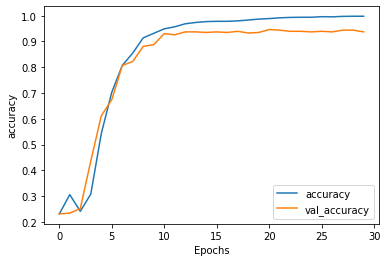

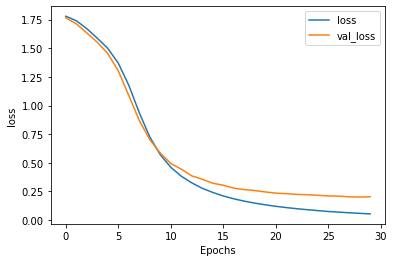

In [24]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [25]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [27]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(1000, 16)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()